# Sparkify Project Workspace

In [1]:
# import libraries for data prep
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession, Window
import datetime
import pyspark.sql.functions as F
import pyspark.sql.types as T

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import libraries required for modelling
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("SparkifyWS") \
    .getOrCreate()

# Load and Clean Dataset
Load a small subset of the dataset to perform initial investigation and model development

In [3]:
#read in data
data = spark.read.json("mini_sparkify_event_data.json")

In [4]:
#create temporary view to work on
data.createOrReplaceTempView("event_data")
data.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
#print schema to understand columns
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
def clean_data(data):
    '''
    input: raw data
    output: cleaned data
    Function that removes duplicate entries and null rows
    '''
    #drop duplicated userIds
    data.select("userId").dropDuplicates().count()
    #drop any rows with nulls in userId or sessionId
    data_clean = data.dropna(subset = ["userId", "sessionId"])
    #drop any rows with empty strings in userId
    data_clean = data_clean.filter(data_clean["userId"] != "")
    return data_clean
data_clean = clean_data(data)

In [7]:
data_clean.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [8]:
def reformat_datetime(data_clean):
    '''
    input: cleaned data
    output: data with columns that convert the epoch timestamps into datetime formatted strings
    Function that reformats the ts columns into datetime formatted strings and saves them in new columns to allow for easier 
    future usage
    '''
    #change ts from epoch to string and input into new column
    get_ts = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    data_clean = data_clean.withColumn("DateTime", get_ts(data_clean.ts))
    #reformat registration from epoch to string and input into new column
    get_registration_ts = F.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    data_clean = data_clean.withColumn("registration_ts", get_registration_ts(data_clean.registration))
    return data_clean
data_clean = reformat_datetime(data_clean)
data_clean.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', DateTime='2018-10-01 00:01:57', registration_ts='2018-09-28 22:22:42'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', DateTime='2018-10-01 00:03:00', registration_ts='2018-09-30 18:20:30')]

In [9]:
#changing location to just the state initials and creating new column
def update_state(data_clean):
    '''
    input: cleaned data with update timestamps
    output: data with a state column included
    Function that adds a column where location is limited to the state in case location is investigated
    '''
    state = F.udf(lambda x:x[-2:])
    data_clean = data_clean.withColumn("state", state(data_clean.location))
    return data_clean
data_clean = update_state(data_clean)
data_clean.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', DateTime='2018-10-01 00:01:57', registration_ts='2018-09-28 22:22:42', state='CA'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', DateTime='2018-10-01 00:03:00', registration_ts='2018-09-30 18:20:30', sta


### Define Churn

Now that the data has been cleaned up, churn events must be defined. This is done by labelling events where a user has been on the page named 'Cancellation confirmation'

In [10]:
#create new updated temporary view
data_clean.createOrReplaceTempView("event_data")
data_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', DateTime='2018-10-01 00:01:57', registration_ts='2018-09-28 22:22:42', state='CA')

In [11]:
#label where a user has cancelled their account, label where they havent and then combine into one dataframe
def label_churn(data_clean):
    '''
    input: fully cleaned data
    output: data with churn events labelled
    Function to label rows with whether a churn even occurs or not
    '''
    churn = spark.sql('SELECT DISTINCT userId, 1 as churn_event FROM EVENT_DATA WHERE Page = "Cancellation Confirmation"')
    no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn_event FROM EVENT_DATA \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM EVENT_DATA WHERE Page = "Cancellation Confirmation")')
    churn_combined = churn.union(no_churn)
    churn_combined.createOrReplaceTempView('churn_nochurn')
    churn_combined = spark.sql('SELECT * FROM churn_nochurn ORDER BY RAND()')
    churn_combined.count()
    data_churned = data_clean.join(churn_combined, on='userId')
    return data_churned
data_churned = label_churn(data_clean)

In [12]:
#create new temporary view with updated fields
data_churned.createOrReplaceTempView("event_data")
data_churned.head(5)

[Row(userId='100010', artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', DateTime='2018-10-08 12:58:54', registration_ts='2018-09-27 02:45:40', state='CT', churn_event=0),
 Row(userId='100010', artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mo

In [13]:
#see how many users are included in the sample of data
data_churned.select(["userId", "churn_event"]).dropDuplicates().count()

225


### Explore Data
Now that the churn events are labelled initial investigation into the data is completed by looking at whether certain factors can predict whether a churn event is more likely to occur like the registration timestamp or account level. These two were chosen to see if a paying user was more likely to cancel their membership or whether when a user registered could influence their experience of the service and therefore their future churn behaviour.

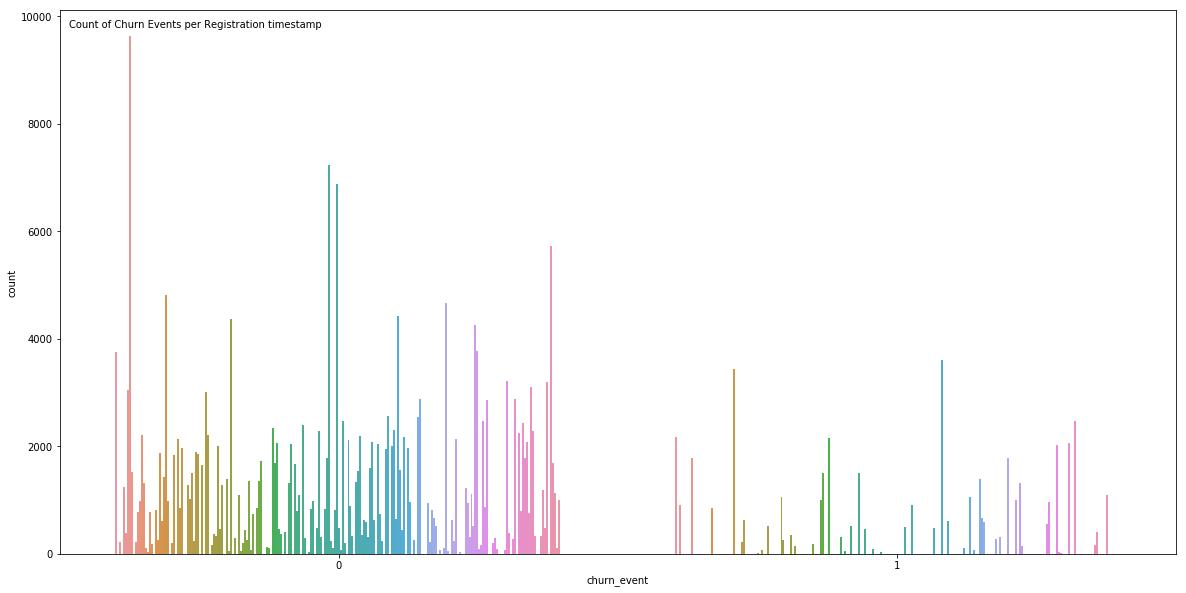

In [14]:
#visually investigate whether registration ts influences churn rate: do we have enough data to do it by ts?
plt.figure(figsize=(20, 10))
data_registration_date = data_churned.groupby(["registration_ts", "churn_event"]).count().sort("registration_ts").toPandas()
sns.barplot(x="churn_event", y="count", hue="registration_ts", data=data_registration_date)
plt.legend([],[], frameon=False).set_title('Count of Churn Events per Registration timestamp')
#certain timestamps do seem to have higher rates of churn

### Registration timestamp and churn events
While there does seem to be registration timestamps where more churn events occur than on others, there is no clear pattern. This would require further investigation as to why certain registration timestamps have more churn events than others. A potential reason could be that subscription lengths influence when a user would cancel their account, however this would only explain churn events for paid users and again would require furture data and investigation to confirm.

Text(0.5,1,'Count of Churn Events Account Level')

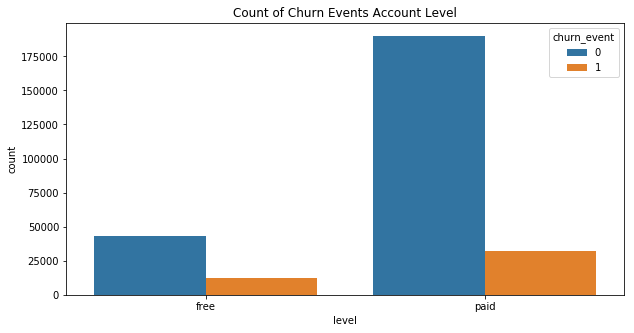

In [15]:
#create plot to compare churn rates for free and paid users
plt.figure(figsize=(10,5))
data_level = data_churned.groupby(['churn_event', 'level']).count().toPandas()
plot = sns.barplot(x='level', y='count', hue='churn_event', data=data_level)
plot.set_title('Count of Churn Events Account Level')

 ### Account Level and churn events
There are more churn events for paid users than for free users, but there are more paid users than free users. If proportionality is taken into account then seem to have a higher churn rate than paid users.


### Feature Engineering
After initial investigation of the data its time to build some features to investigate in the future classifications models. The features chosen are as follows:

    Thumbs up: are users who like songs more or less likely to cancel their account
    Thumbs down: are users who dislike songs more or less likely to cancel their account
    Gender: does gender predict churn rate
    Total songs: does the number of songs listened to predict churn rate
    Upgrade: if a user upgrades from a free to a paid account, can this predict churn events
    Add friends: if a user has added friends to their account, can this predict churn events

These features were chosen as potential features that could logically influence a user's churn behaviour.
    

In [16]:
#create feature for thumbs up
thumbs_up = data_churned.select('userID','page').where(data_churned.page == 'Thumbs Up').groupBy('userID').count() \
             .withColumnRenamed('count', 'thumbs_up') 
thumbs_up.describe().show()

+-------+------------------+-----------------+
|summary|            userID|        thumbs_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [17]:
#create feature for thumbs down
thumbs_down = data_churned.select('userID','page').where(data_churned.page == 'Thumbs Down').groupBy('userID').count() \
                 .withColumnRenamed('count', 'thumbs_down')
thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userID|       thumbs_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [18]:
##create feature for gender
gender = data_churned.select('userId', 'gender').dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender')\
        .select('userId',F.col('gender').cast('int')).withColumnRenamed('gender', 'gender_total')
gender.describe().show()

+-------+------------------+------------------+
|summary|            userId|      gender_total|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.4622222222222222|
| stddev|105396.47791907164|0.4996824388374478|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [19]:
#create feature for how many songs does each user listen to
total_songs= data_churned.select('userId', 'song').groupby('userId').count().withColumnRenamed('count', 'songs_total')
total_songs.describe().show()

+-------+------------------+-----------------+
|summary|            userId|      songs_total|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [20]:
#create feature for upgrade
upgrade = data_churned.select('userID','page').where(data_churned.page == 'Upgrade').groupBy('userID').count() \
             .withColumnRenamed('count', 'upgrade') 
upgrade.describe().show()

+-------+------------------+------------------+
|summary|            userID|           upgrade|
+-------+------------------+------------------+
|  count|               168|               168|
|   mean| 61369.56547619047|2.9702380952380953|
| stddev|103748.38346043936|2.5557861915159594|
|    min|               100|                 1|
|    max|                99|                15|
+-------+------------------+------------------+



In [21]:
#create feature for adding friends
add_friend = data_churned.select('userID','page').where(data_churned.page == 'Add Friend').groupBy('userID').count() \
             .withColumnRenamed('count', 'add_friend') 
add_friend.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [22]:
#rename churn_event to label
label = data_churned.select('userId', F.col('churn_event').alias('label')).dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [23]:
#join features together
features_joined = thumbs_up.join(thumbs_down, 'userId', 'outer').join(gender, 'userId', 'outer')\
    .join(total_songs, 'userId', 'outer').join(upgrade, 'userId', 'outer')\
    .join(add_friend, 'userId', 'outer').join(label, 'userId', 'outer').fillna(0)
features_joined.show(5)

+------+---------+-----------+------------+-----------+-------+----------+-----+
|userID|thumbs_up|thumbs_down|gender_total|songs_total|upgrade|add_friend|label|
+------+---------+-----------+------------+-----------+-------+----------+-----+
|100010|       17|          5|           1|        381|      2|         4|    0|
|200002|       21|          6|           0|        474|      2|         4|    0|
|   125|        0|          0|           0|         11|      0|         0|    1|
|   124|      171|         41|           1|       4825|      0|        74|    0|
|    51|      100|         21|           0|       2464|      0|        28|    1|
+------+---------+-----------+------------+-----------+-------+----------+-----+
only showing top 5 rows



In [24]:
#drop userID
features = features_joined.drop('userID')
features.show()

+---------+-----------+------------+-----------+-------+----------+-----+
|thumbs_up|thumbs_down|gender_total|songs_total|upgrade|add_friend|label|
+---------+-----------+------------+-----------+-------+----------+-----+
|       17|          5|           1|        381|      2|         4|    0|
|       21|          6|           0|        474|      2|         4|    0|
|        0|          0|           0|         11|      0|         0|    1|
|      171|         41|           1|       4825|      0|        74|    0|
|      100|         21|           0|       2464|      0|        28|    1|
|        7|          1|           0|        201|      2|         1|    0|
|       81|         14|           0|       2278|      0|        31|    0|
|      163|         29|           1|       3437|      1|        33|    1|
|       58|          3|           1|       1002|      2|        11|    0|
|       17|          3|           0|        310|      0|         6|    1|
|       96|         17|           1|  

## Modeling
Now that features have been created we can begin selecting and testing classification models. Spark supports 5 potential classification algorithms.

### Implementation
First the selected features were scaled and vectorized. Then data was seperated into training and test data. Out of the 5 available classification algorithms, 4 initially implemented. These were done without any parameter tuning, to give us an initial idea about how well each model performed. The effectiveness of these models will be judged mainly by their F1 result as we are working with an imbalanced data set and using the weighted average of precision and recall will give us a better idea of model performance than accuracy.

After all 4 models were run the most successful was selected to then refine further using gridsearch and parameter tuning, to try and improve the F1 value. 


In [25]:
#assemble vector
columns = ['thumbs_up', 'thumbs_down', 'gender_total', 'songs_total', 'upgrade', 'add_friend']
assembler = VectorAssembler(inputCols = columns, outputCol='numberFeatures')
vector_data = assembler.transform(features)
#standardize the features
scaler = StandardScaler(inputCol= 'numberFeatures', outputCol = 'features', withStd = True)
scaler_model = scaler.fit(vector_data)
scaled_data = scaler_model.transform(vector_data)

In [37]:
#seperate test and training data
train, test = scaled_data.randomSplit([0.8, 0.2], seed=40)

### Logistic Regression
First a logistic regression will be implemented to see how well it performs. Logistic regressions are often used as first try algorithms due to ease of use, quick to run, and robust nature.

In [27]:
#complete a logistic regression as its a good starting place
logReg = LogisticRegression(maxIter=5, regParam=0.0, fitIntercept=False)
f_score = MulticlassClassificationEvaluator(metricName = "f1")
logReg_train = logReg.fit(train)
logReg_test = logReg_train.transform(test)

result = MulticlassClassificationEvaluator(predictionCol = "prediction")
accuracy = result.evaluate(logReg_test,{result.metricName: 'accuracy'})
f1 = result.evaluate(logReg_test,{result.metricName: 'f1'})
print(accuracy)
print(f1)

0.7659574468085106
0.7281727990947847


### Result: Logistic Regression
The results from the logistic regression are not bad with an accuracy of 0.766 and an F1 value of 0.7281

### Random Forest
Next a random forest classifier will be run. Random forest models are based on decision trees where where they are trained in parallel. Random forest was chosen due to its ability to work well with large data sets which will become useful when run on the full dataset. However random forest classifications are prone to overfitting so this will need to be kept in mind when analyzing results.


In [28]:
#complete Random forest classifier
randFor = RandomForestClassifier()
f_score = MulticlassClassificationEvaluator(metricName = "f1")
randFor_train = randFor.fit(train)
randFor_test = randFor_train.transform(test)

result = MulticlassClassificationEvaluator(predictionCol = "prediction")
accuracy = result.evaluate(randFor_test,{result.metricName: 'accuracy'})
f1 = result.evaluate(randFor_test,{result.metricName: 'f1'})
print(accuracy)
print(f1)

0.7659574468085106
0.701358625993335


### Result: Random Forest
The results from the random forest classifier are stronger with an accuracy of 0.809 and a F1 score of 0.756. These values are not extremely high suggesting overfitting has not occured.

### Gradient Boosting Classifier
Next a gradient boosting classifier will be run. This algorithm is also based on decision trees, however the unlike the random forest classifers the decision trees are processed sequentially rather then in parallel. Gradient boosting classifiers work well with imbalanced data sets, making it ideal for this training set. However gradient boosting classifiers are also prone to overfitting so this will need to be kept in mind when analyzing results.


In [29]:
#complete a gradient boosting classifier
gradBoo = GBTClassifier()
f_score = MulticlassClassificationEvaluator(metricName = "f1")

gradBoo_train = gradBoo.fit(train)
gradBoo_test = gradBoo_train.transform(test)

result = MulticlassClassificationEvaluator(predictionCol = "prediction")
accuracy = result.evaluate(gradBoo_test,{result.metricName: 'accuracy'})
f1 = result.evaluate(gradBoo_test,{result.metricName: 'f1'})
print(accuracy)
print(f1)

0.723404255319149
0.7288391190742813


### Result: Gradient Boosting Classifier
The results from the gradient boosting classifier are weaker with an accuracy of 0.723 and a F1 score of 0.729. Again these numbers are not extremely high so overfitting is not likely to have occured.

### Linear Support Vector Machine
The final algorithm that will be tested is a linear support vector machine. A linear support vector machine differentiates between two classifications by creating a hyperplane in the a a space that has dimensions equal to the number of features. It does this as many times as is required to find the maximum diststance between data points of both classifications. SVM was chosen as it works well with many features. However it perfoms poorly with large datasets so unless it is highly accurate it is unlikely to be the right choice for the full data set. 

In [ ]:
#complete linear support vector machine with a OneVsRest 
linSVC = LinearSVC()
f_score = MulticlassClassificationEvaluator(metricName = "f1")
linSVC_train = linSVC.fit(train)
linSVC_test = linSVC_train.transform(test)

result = MulticlassClassificationEvaluator(predictionCol = "prediction")
accuracy = result.evaluate(linSVC_test,{result.metricName: 'accuracy'})
f1 = result.evaluate(linSVC_test,{result.metricName: 'f1'})
print(accuracy)
print(f1)

### Result: Linear SVC
The linear SVC performs well with an accuracy of 0.809 and an F1 value of 0.723. However it was by far the slowest to run and would not be suitable for the full dataset.

### Algorithm Choice for parameter tuning
Looking at the F1 values and considering the implications of running the model on the full data set the random forest model seems to perform the best with the highest F1 value.

#### Initial Random Forest Classification Performance:  accuracy of 0.809 and a F1 score of 0.756 

### Improving the Random Forest Classification
From this we will further refine the model by using gridsearch to select and then tune the parameters in an attempt to improve the F1 value of the model. I will also increase the size of the test data to increase the number of churn events in the test data set, as we have a low number of churn events in this data subset.

In [31]:
#find best hyperparameters to refine for random forest
#first update the split
train, test = scaled_data.randomSplit([0.7, 0.3], seed=40)
randFor_tuned = RandomForestClassifier()

### Parameter choice
The two parameters chosen to tune are number of trees and the max depth. These are the two most common chosen to tune as they are the most related to the accuracy of the model, while the other available parameters are used more to improve model performance. These may become more relevant when working with the full data set. 
### Parameter Value Choice
CrossValidation was used to find the best hyperparameters over a 10 folds, a common fold value to choose. While this is computationally expensive it is far more effective than tuning parameters by hand. The ranges for maxDepth and numTrees were selected as they are common choices used to investigate a broad enough range of parameters to effectively tune the model.

In [32]:
#set the grid and apply in cross validator
f_score = MulticlassClassificationEvaluator(metricName = "f1")
paramGrid = ParamGridBuilder()\
       .addGrid(randFor_tuned.maxDepth,[5,25]) \
       .addGrid(randFor_tuned.numTrees,[1,100]) \
       .build()

crossval_RF = CrossValidator(estimator=randFor_tuned,
                           evaluator=f_score,
                           estimatorParamMaps=paramGrid,
                           numFolds=10)

In [33]:
#run random forest classifier again and return accuracy
randFor_train_tuned = randFor_tuned.fit(train)
randFor_test_tuned = randFor_train_tuned.transform(test)

result = MulticlassClassificationEvaluator(predictionCol = "prediction")
accuracy = result.evaluate(randFor_test_tuned,{result.metricName: 'accuracy'})
f1 = result.evaluate(randFor_test_tuned,{result.metricName: 'f1'})
print(accuracy)
print(f1)

0.7941176470588235
0.7495098039215687


### Results of Parameter tuning
After having ran several options to tune the parameters, no variation improved the results. In all cases the F1 value decreased (0.744) and the accuracy of the model decreased (0.7941). Since we are using F1 value to judge model performance this suggests that our model actually worsened after parameter tuning. This is probably due to increasing the size of the test data rather than a parameter change. This suggests that the default parameter selection is already the most effective, but the imbalanced data set is limiting the model performance. We probably would not have noted this decrease performance if we had tuned the parameters of the gradient booting classification as this model is more adept at managing unbalanced data sets

### Feature Importance
Now that the model has been tuned it's time to look at which features are most relevant for predicting churn_events

In [34]:
#Feature importance plot
randFor_train_tuned.featureImportances

SparseVector(6, {0: 0.1952, 1: 0.2469, 2: 0.0285, 3: 0.1964, 4: 0.0882, 5: 0.2447})

In [35]:
importances = [0.1782, 0.02285, 0.0239, 0.1912, 0.115, 0.2631]
features = ["thumbs_up", "thumbs_down", "gender_total", "songs_total", "upgrade", "add_friend"]

Text(0.5,1,'Feature Importance')

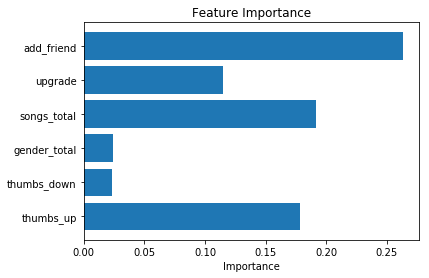

In [36]:
featureArray = np.arange(len(features))
plt.barh(featureArray, importances, align = 'center')
plt.xlabel('Importance')
plt.yticks(featureArray, features)
plt.title('Feature Importance')

## Summary
In this project I aimed to investigate what features could predict a customer to cancel their membership, a churn event, with a fictional music streaming app, Sparkify. This was done by completing the following steps:
    1. data was cleaned
    2. initial visual investigation into the data
    3. feature selection
    4. feature engineering
    5. features vectorized and scaled
    6. data split into training and test sets
    7. 4 potential classification models were applied
    8. Highest performing model was selected: chosen by selecting highest F1 value
    9. Models paraments were tuned by selecting the relevant parameters and using crossValidation to select optimum values
    10. Feature importance was calculated and displayed

The model that showed the highest F1 value initially and had the most relevant characteristics was the random forest classification algorithm. This was used to investigate the included features ability to predict churn rates. The results of this model, after tuning the parameters, were an accuracy of 0.7941 and a F1 value of 0.7438. Which is lower before parameter tuning and the change in size of training and test data. This suggests that the change in data set sizes led to an even more unbalanced data set removing any possible improvements parameter tuning could have made.

The results suggest that the model, while not performing poorly is not able to fully classify all the data. This suggests that features chosen to include do not cover all the variation in the churn events. It also suggests that the model selected may not have been ideal to work with the current data set. The random forest classication is a model known to deal well with big data sets. This was considred a positive as this model should be applied to a much larger full data set. It does not however deal well with unbalanced data sets, which our smaller data set was. 

Investigation into the feature importance in the model showed that if a user added a friend (0.2631) had the strongest influence on churn rates. This was followed by thumbs up (0.1782) and song total (0.1912) which had similar levels of importance. Then upgrade has a slightly lower level of importance (0.115). Finally thumbs down (0.02285) and gender (0.0239) had the lowest influence of churn events. This suggests that some of the features selected were actually relevant to user churn. However thumbs down and gender had very little influence. Improved feature selection is required. 

### Improvements and Reflections
The main improvement available in this investigation is feature choice. The high number of relevant and related features made choosing features difficult and clearly limited the effectiveness of the model. This investigation spent too little time on this step, likely decreasing the effectiveness of the conclusions inferred from the model. Spending more time investigating the cleaned data prior to feature selection could lead to more effective feature choice and a more accurate model. Also investigating how features are correlated could help us stop this from influencing model performance

Another improvement would be to build, train, and test this model on a bigger data set with a more balanced train and test data sets. This dataset was unbalanced with few churn events in the test dataset limiting our ability to fully test the models ability predict churn events.

A further solution to working with the unbalanced data set would be to choose a model more adept at working with such a data set. Choosing a gradient boosting classification model could have limited the effect that the unbalanced data set had on our results. However in this investigation we chose the random forest classifier as it initially performed best but also was the most suited to future usage with the full data set. This limited our current results. 

On the other hand using smaller datasets would allow us to work with this data without spark. This would give us a wider range of avaible models to use allowing us to create more accurate models, not currently available to use with the larger dataset. While this would have been an effective short term solution limiting the future ability to apply the model to the full data set.